# Libraries

In [ ]:
!pip install -q gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gdown
import numpy as np
from scipy.sparse import csr_matrix, vstack  # Thêm dòng này để tránh lỗi
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:


file_id = "1-YuoONLHzXvtk-PcUlOXoXcrUELW_kuU"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "job_tfidf.npy", quiet=False)

candidate_file_id = "1SqIuhPHl5RvjqIKKS2Z3MluMIZrgvNjD"
gdown.download(f"https://drive.google.com/uc?id={candidate_file_id}", "candidate_tfidf.npy", quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1-YuoONLHzXvtk-PcUlOXoXcrUELW_kuU
To: /content/job_tfidf.npy
100%|██████████| 32.0M/32.0M [00:00<00:00, 52.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SqIuhPHl5RvjqIKKS2Z3MluMIZrgvNjD
To: /content/candidate_tfidf.npy
100%|██████████| 3.76M/3.76M [00:00<00:00, 43.0MB/s]


'candidate_tfidf.npy'

# Data job and candidate

In [ ]:


data_job = np.load("job_tfidf.npy", allow_pickle=True)

# Check if the loaded data is a 0-dimensional array containing a sparse matrix
if isinstance(data_job, np.ndarray) and data_job.ndim == 0 and isinstance(data_job.item(), csr_matrix):
    data_job = data_job.item()  # Extract the sparse matrix from the 0-dimensional array

print(data_job.shape)
print(data_job)


(21858, 10000)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2661913 stored elements and shape (21858, 10000)>
  Coords	Values
  (0, 1443)	0.0573462651014635
  (0, 3233)	0.039426356013785746
  (0, 5379)	0.04804128387928418
  (0, 9987)	0.07825495273848215
  (0, 5101)	0.10700733485716651
  (0, 7651)	0.06720587930711498
  (0, 8697)	0.04370944896630568
  (0, 5581)	0.041069509231569386
  (0, 4292)	0.4378496288935914
  (0, 4513)	0.08258529887934615
  (0, 1146)	0.06572377385029238
  (0, 5188)	0.035281321585832505
  (0, 7720)	0.15078793858608372
  (0, 8611)	0.14480024462648788
  (0, 8155)	0.05653941604618476
  (0, 2043)	0.14819761323188693
  (0, 3939)	0.07298863918454825
  (0, 4296)	0.08845718955640416
  (0, 1353)	0.06852323793736669
  (0, 1547)	0.11431146873470546
  (0, 7990)	0.10758077431855463
  (0, 584)	0.056470350377893025
  (0, 4435)	0.0662211526092531
  (0, 2530)	0.05594658103794712
  (0, 4138)	0.06198927616222249
  :	:
  (21857, 3661)	0.0356743725642982
  (21857, 2163)	

In [ ]:


data_candidate = np.load("candidate_tfidf.npy", allow_pickle=True)  # thêm allow_pickle nếu bị lỗi

# Check if the loaded data is a 0-dimensional array containing a sparse matrix
if isinstance(data_candidate, np.ndarray) and data_candidate.ndim == 0 and isinstance(data_candidate.item(), csr_matrix):
    data_candidate = data_candidate.item() # Extract the sparse matrix from the 0-dimensional array

print(data_candidate.shape)
print(data_candidate)

(44963, 10000)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 298562 stored elements and shape (44963, 10000)>
  Coords	Values
  (0, 1443)	0.25963941480197417
  (0, 4089)	0.19569206763872085
  (0, 1128)	0.7770969044962406
  (0, 3896)	0.5084762531316298
  (0, 3233)	0.17850571410503913
  (1, 4290)	0.35218050366267983
  (1, 4103)	0.31383218417010994
  (1, 9412)	0.809229421631295
  (1, 3621)	0.20207737742316967
  (1, 1479)	0.202336907094604
  (1, 4855)	0.2021150804526045
  (2, 5379)	0.41278182362392685
  (2, 8989)	0.18845811113689978
  (2, 3230)	0.5511195877872845
  (2, 3994)	0.4467384030581221
  (2, 4006)	0.5392464238385543
  (3, 3621)	0.15362461490038432
  (3, 1479)	0.15382191628234868
  (3, 4855)	0.15365327774949372
  (3, 9740)	0.4318900543065886
  (3, 2988)	0.4161112573368259
  (3, 9164)	0.3243398049201346
  (3, 7875)	0.49819756904084384
  (3, 2133)	0.4648163526163337
  (4, 4089)	0.5434280618173101
  :	:
  (44958, 9116)	0.6139546630230173
  (44959, 5379)	0.10823187729912

# Process batch

In [ ]:

batch_size = 1000
num_candidates = data_candidate.shape[0]
num_jobs = data_job.shape[0]
similarity_matrix = np.zeros((num_candidates, num_jobs))

for i in range(0, num_candidates, batch_size):
    print(f"Processing batch {i} to {i + batch_size}")
    candidate_batch = data_candidate[i:i + batch_size]
    candidate_dense = candidate_batch.toarray()

    # data_job là sparse nên cosine_similarity vẫn hoạt động tốt
    batch_similarity = cosine_similarity(candidate_dense, data_job)

    similarity_matrix[i:i + batch_size] = batch_similarity


Processing batch 0 to 1000
Processing batch 1000 to 2000
Processing batch 2000 to 3000
Processing batch 3000 to 4000
Processing batch 4000 to 5000
Processing batch 5000 to 6000
Processing batch 6000 to 7000
Processing batch 7000 to 8000
Processing batch 8000 to 9000
Processing batch 9000 to 10000
Processing batch 10000 to 11000
Processing batch 11000 to 12000
Processing batch 12000 to 13000
Processing batch 13000 to 14000
Processing batch 14000 to 15000
Processing batch 15000 to 16000
Processing batch 16000 to 17000
Processing batch 17000 to 18000
Processing batch 18000 to 19000
Processing batch 19000 to 20000
Processing batch 20000 to 21000
Processing batch 21000 to 22000
Processing batch 22000 to 23000
Processing batch 23000 to 24000
Processing batch 24000 to 25000
Processing batch 25000 to 26000
Processing batch 26000 to 27000
Processing batch 27000 to 28000
Processing batch 28000 to 29000
Processing batch 29000 to 30000
Processing batch 30000 to 31000
Processing batch 31000 to 3200

In [ ]:

top_k = 20

# Initialize empty arrays to store the results
top_job_indices = np.zeros((num_candidates, top_k), dtype=np.int32)
top_job_scores = np.zeros((num_candidates, top_k), dtype=np.float32)

# Process one candidate at a time to conserve memory
for i in range(num_candidates):
    # Get similarity scores for the current candidate (a single row)
    candidate_scores = similarity_matrix[i, :]

    # Sort only this single row. This is a much smaller operation.
    top_indices_for_candidate = np.argsort(-candidate_scores)[:top_k]

    # Store the top k indices and scores for this candidate
    top_job_indices[i, :] = top_indices_for_candidate
    top_job_scores[i, :] = candidate_scores[top_indices_for_candidate]

In [ ]:
for i in range(5):
    print(f"Candidate {i}:")
    for j in range(top_k):
        print(f"  Top-{j+1} Job Index: {top_job_indices[i, j]} | Similarity: {top_job_scores[i, j]:.4f}")

Candidate 0:
  Top-1 Job Index: 18950 | Similarity: 0.6967
  Top-2 Job Index: 6100 | Similarity: 0.4489
  Top-3 Job Index: 8260 | Similarity: 0.4489
  Top-4 Job Index: 18553 | Similarity: 0.3942
  Top-5 Job Index: 3596 | Similarity: 0.3906
  Top-6 Job Index: 11862 | Similarity: 0.3825
  Top-7 Job Index: 5060 | Similarity: 0.3814
  Top-8 Job Index: 14985 | Similarity: 0.3762
  Top-9 Job Index: 2892 | Similarity: 0.3643
  Top-10 Job Index: 11275 | Similarity: 0.3561
Candidate 1:
  Top-1 Job Index: 12096 | Similarity: 0.7373
  Top-2 Job Index: 20161 | Similarity: 0.4252
  Top-3 Job Index: 5944 | Similarity: 0.3806
  Top-4 Job Index: 20777 | Similarity: 0.3622
  Top-5 Job Index: 19540 | Similarity: 0.3592
  Top-6 Job Index: 8102 | Similarity: 0.3479
  Top-7 Job Index: 18809 | Similarity: 0.3474
  Top-8 Job Index: 18603 | Similarity: 0.3077
  Top-9 Job Index: 12210 | Similarity: 0.2621
  Top-10 Job Index: 21711 | Similarity: 0.2621
Candidate 2:
  Top-1 Job Index: 16204 | Similarity: 0.3698


In [ ]:
df_candidate = pd.read_csv("/content/drive/Shareddrives/PTDL WEB/PTDL WEB - FINAL/Dataset/Feature Engineering Data/processed_candidate.csv")
display(df_candidate.head())

,Unnamed: 0,user_url,userid,user_name,industry,workplace_desired,desired_salary,gender,marriage,age,work_experience,desired_job_translated,proc_desired_job,proc_industry,proc_workplace
0,0,https://timviec365.vn/uvtv2/dao-huu-tai-uv1111...,1111684868,Đào Hữu Tài,Kd Bất Động Sản,Hà Nội,Thỏa Thuận,Nam,Độc Thân,38.0,Dưới 1 năm,Chuyên Viên Kinh Doanh Bất Động Sản,chuyên_viên kinh_doanh bất_động_sản,kd bất_động_sản,h_nội
1,1,https://timviec365.vn/uvtv2/ho-vinh-duc-uv199803,199803,Hồ Vĩnh Đức,Xây Dựng,Hồ Chí Minh,Thỏa Thuận,Nam,Khác,37.0,Không yêu cầu kinh nghiệm,Kỹ Sư Kinh Tế Xây Dựng,kỹ_sư kinh_tế y_dựng,y_dựng,hồ chí minh
2,2,https://timviec365.vn/uvtv2/ngo-thi-bich-tram-...,1271594,Ngô Thị Bích Trâm,Khách Sạn - Nhà Hàng,Khánh Hòa,Thỏa Thuận,Nam,Độc Thân,NaN,Chưa Có Kinh Nghiệm,Nhân Viên Nhà Hàng,nh viên nh h_ng,khách_sạn nh h_ng,khánh_hòa
3,3,https://timviec365.vn/uvtv2/vo-ba-loi-uv160413,160413,Võ Bá Lợi,Giao Thông Vận Tải - Thủy Lợi - Cầu Đường,Hồ Chí Minh,Thỏa Thuận,Nam,Độc Thân,NaN,Chưa Có Kinh Nghiệm,Đầu Bếp,đầu_bếp,giao_thông vận_tải thủy_lợi cầu_đường,hồ chí minh
4,4,https://timviec365.vn/uvtv2/vo-thi-thuy-van-uv...,1111646039,Võ Thị Thuỳ Vân,Quản Trị Kinh Doanh,Đồng Nai,Thỏa Thuận,Nữ,Độc Thân,21.0,Chưa Có Kinh Nghiệm,Thực Tập Sinh Kinh Doanh,thực_tập_sinh kinh_doanh,quản_trị kinh_doanh,đồng_nai


In [ ]:
df_job= pd.read_csv("/content/drive/Shareddrives/PTDL WEB/PTDL WEB - FINAL/Dataset/Feature Engineering Data/df_job_processed.csv")
display(df_job.head())

,Job_Name,Company_name,Location,Salary,Time,Benefit,Description,Requirement,URL,Industry,Type,Requirement_processed,Type_processed,Description_processed,Industry_processed
0,Chuyên Viên Hỗ Trợ Kỹ Thuật ( ô tô thương mại)...,CÔNG TY CP TM DV AN SƯƠNG,Hà Nội,Cạnh tranh,10/31/2025,"Chế độ bảo hiểm, Du Lịch, Đồng phục, Chế độ th...",• Hỗ trợ kỹ thuật & hướng dẫn sửa chữa cho hệ ...,• Tốt nghiệp đại học ngành Cơ khí ô tô. • Tối ...,https://careerviet.vn/vi/tim-viec-lam/chuyen-v...,Cơ khí / Ô tô / Tự động hóa,Nhân viên chính thức,tốt_nghiệp đại_học ng nh cơ_khí ô_tô tối_thiểu...,nh n viên chính_thức,hỗ_trợ kỹ_thuật hướng_dẫn sửa_chữa hệ_thống đạ...,cơ_khí ô_tô tự_động_hóa
1,CHUYÊN VIÊN PHỤ TÙNG (MỚI),CÔNG TY CP TM DV AN SƯƠNG,Hồ Chí Minh,"5,000,000 - 10,000,000",9/30/2025,"Chế độ bảo hiểm, Du Lịch, Đồng phục, Chế độ th...","- Xây dựng chính sách, kế hoạch và KPI kinh do...","-Tốt nghiệp ĐH ngành Cơ khí ô tô, Logistics, K...",https://careerviet.vn/vi/tim-viec-lam/chuyen-v...,Tiếp thị / Marketing,Nhân viên chính thức,tốt_nghiệp đh ng nh cơ_khí ô_tô logistics kinh...,nh n viên chính_thức,x y dựng chính_sách kế_hoạch v kpi kinh_doanh ...,tiếp_thị marketing
2,PHÓ TRƯỞNG BỘ PHẬN PHÁP LÝ – ĐĂNG KIỂM XE CBU/...,CÔNG TY CP TM DV AN SƯƠNG,Hà Nội,Cạnh tranh,8/31/2025,"Chế độ bảo hiểm, Du Lịch, Đồng phục, Chế độ th...",Mô tả công việc: - Quản lý hồ sơ pháp lý – kỹ ...,"- Tốt nghiệp kỹ thuật ô tô, cơ khí, luật hoặc ...",https://careerviet.vn/vi/tim-viec-lam/pho-truo...,Luật / Pháp lý,Nhân viên chính thức,tốt_nghiệp kỹ_thuật ô_tô cơ_khí luật liên_quan...,nh n viên chính_thức,mô_tả công_việc quản_lý hồ_sơ pháp_lý kỹ_thuật...,luật pháp_lý
3,Tài Xế Lái Xe Cho Giám Đốc (MỚI),CÔNG TY CP TM DV AN SƯƠNG,Hồ Chí Minh,"5,000,000 - 10,000,000",6/30/2025,"Chế độ bảo hiểm, Du Lịch, Đồng phục, Chế độ th...","Mô tả công việc Phụ trách đưa đón, chuyên chở ...","Nam, sức khỏe tốt, không bị cận; GPLX hạng B2 ...",https://careerviet.vn/vi/tim-viec-lam/tai-xe-l...,Vận chuyển / Giao nhận / Kho vận,Nhân viên chính thức,nam sức_khỏe tốt cận gplx hạng b2 trở lên sẵn ...,nh n viên chính_thức,mô_tả công_việc phụ_trách đưa_đón chuyên_chở l...,vận_chuyển_giao_nhận kho vận
4,Phiên dịch viên tiếng Trung Quốc (MỚI),CÔNG TY CP TM DV AN SƯƠNG,Hà Nội,"15,000,000 - 20,000,000",8/31/2025,"Chế độ bảo hiểm, Du Lịch, Chế độ thưởng, Chăm ...","- Phiên dịch, biên dịch tài liệu kỹ thuật và n...",- Thành thạo tiếng Trung - Ưu tiên ứng viên có...,https://careerviet.vn/vi/tim-viec-lam/phien-di...,Hành chính / Thư ký,Nhân viên chính thức,th nh thạo tiếng trung ưu_tiên ứng_viên kinh_n...,nh n viên chính_thức,phiên_dịch biên_dịch t_i liệu kỹ_thuật v nội_d...,h nh chính thư_ký


# Save final file

In [ ]:

rows = []
for candidate_id in range(num_candidates):
    # Use the PhoBERT similarity matrix
    candidate_scores = similarity_matrix[candidate_id]
    top_indices = np.argsort(-candidate_scores)[:top_k]

    for rank in range(len(top_indices)):
        job_id = top_indices[rank]
        score = candidate_scores[job_id]
        rows.append({
            "candidate_id": candidate_id,
            "job_id": job_id,
            "similarity_score": score,
            "rank": rank + 1
        })

df = pd.DataFrame(rows)

In [16]:
# ========= CONFIG ========= #
top_k_job2job = 5
top_k_similar_jobs = []

for i in tqdm(range(data_job.shape[0]), desc="🔁 Computing job-to-job"):
    # ✅ Ensure 2D shape with i:i+1
    sim_scores = cosine_similarity(data_job[i:i+1], data_job).flatten()
    sim_scores[i] = -1  # exclude self

    top_indices = np.argpartition(sim_scores, -top_k_job2job)[-top_k_job2job:]
    top_scores = sim_scores[top_indices]
    sorted_top_k = sorted(zip(top_indices, top_scores), key=lambda x: x[1], reverse=True)

    for rank, (j_idx, score) in enumerate(sorted_top_k):
        top_k_similar_jobs.append({
            'source_job_id': i,
            'expanded_job_id': j_idx,
            'similarity_score_job2job': float(score),
            'job2job_rank': rank + 1
        })

job_to_job_df = pd.DataFrame(top_k_similar_jobs)

# ========= MERGE TO EXPAND CANDIDATE JOB LIST ========= #
# Note: df has candidate_id, job_id, similarity_score, rank

expanded_df = df.merge(
    job_to_job_df,
    how='left',
    left_on='job_id',
    right_on='source_job_id'
)

expanded_df['hybrid_score'] = (
    0.7 * expanded_df['similarity_score'] +
    0.3 * expanded_df['similarity_score_job2job']
)

# Drop missing expanded jobs and deduplicate
expanded_df = expanded_df.dropna(subset=['expanded_job_id'])
expanded_df = expanded_df.sort_values(
    by=['candidate_id', 'expanded_job_id', 'hybrid_score'],
    ascending=[True, True, False]
).drop_duplicates(subset=['candidate_id', 'expanded_job_id'])

# Preview
expanded_df.head()

🔁 Computing job-to-job:   1%|          | 118/21858 [00:09<29:49, 12.15it/s]


KeyboardInterrupt: 

In [17]:
expanded_df = df.merge(
    job_to_job_df,
    how='left',
    left_on='job_id',
    right_on='source_job_id'
)

expanded_df['hybrid_score'] = (
    0.7 * expanded_df['similarity_score'] +
    0.3 * expanded_df['similarity_score_job2job']
)

# Drop missing expanded jobs and deduplicate
expanded_df = expanded_df.dropna(subset=['expanded_job_id'])
expanded_df = expanded_df.sort_values(
    by=['candidate_id', 'expanded_job_id', 'hybrid_score'],
    ascending=[True, True, False]
).drop_duplicates(subset=['candidate_id', 'expanded_job_id'])

# Preview
expanded_df.head()

,candidate_id,job_id,similarity_score,rank,source_job_id,expanded_job_id,similarity_score_job2job,job2job_rank,hybrid_score
35,0,14985,0.376159,8,14985,324,0.591625,1,0.440799
37,0,14985,0.376159,8,14985,619,0.580738,3,0.437533
36,0,14985,0.376159,8,14985,1716,0.586019,2,0.439117
15,0,18553,0.394233,4,18553,1975,0.716981,1,0.491058
4,0,18950,0.696722,1,18950,2203,0.496166,5,0.636555


# Add Heuristic-Based Ground Truth

In [18]:
def normalize_text(text):
    if pd.isna(text):
        return ""
    return re.sub(r"[^\w\s]", "", text.lower().strip())

def parse_numeric_value(value_str):
    if pd.isna(value_str):
        return None
    cleaned_str = re.sub(r"[^\d\-\.]", "", str(value_str))
    if "-" in cleaned_str:
        try:
            parts = cleaned_str.split("-")
            if len(parts) == 2:
                return (float(parts[0]) + float(parts[1])) / 2
            elif len(parts) == 1 and cleaned_str.startswith('-'):
                return float(cleaned_str)
            elif len(parts) == 1 and cleaned_str.endswith('-'):
                return float(cleaned_str.rstrip('-')) # Corrected typo here
        except ValueError:
            return None
    elif cleaned_str.replace('.', '', 1).isdigit():
        try:
            return float(cleaned_str)
        except ValueError:
            return None
    elif normalize_text(value_str) == 'duoi 1 nam':
        return 0.5
    return None

def heuristic_label(candidate, job):
    def normalize_text(text):
        if pd.isna(text):
            return ""
        return re.sub(r"[^\w\s]", "", str(text).lower().strip())

    def parse_numeric_value(value_str):
        if pd.isna(value_str):
            return None
        cleaned_str = re.sub(r"[^\d\-\.]", "", str(value_str))
        if "-" in cleaned_str:
            try:
                parts = cleaned_str.split("-")
                if len(parts) == 2:
                    return (float(parts[0]) + float(parts[1])) / 2
                elif len(parts) == 1 and cleaned_str.startswith('-'):
                    return float(cleaned_str)
                elif len(parts) == 1 and cleaned_str.endswith('-'):
                    return float(cleaned_str.rstrip('-'))
            except ValueError:
                return None
        elif cleaned_str.replace('.', '', 1).isdigit():
            try:
                return float(cleaned_str)
            except ValueError:
                return None
        elif normalize_text(value_str) == 'duoi 1 nam':
            return 0.5
        return None

    desired_job = normalize_text(candidate.get("desired_job_translated", ""))
    job_title = normalize_text(job.get("Job_Name", ""))
    industry_cand = normalize_text(candidate.get("industry", ""))
    industry_job = normalize_text(job.get("Industry", ""))
    location_cand = normalize_text(candidate.get("workplace_desired", ""))
    location_job = normalize_text(job.get("Location", ""))

    experience_cand = parse_numeric_value(candidate.get("work_experience"))
    required_exp = parse_numeric_value(job.get("Required_Experience"))
    expected_salary = parse_numeric_value(candidate.get("expected_salary"))
    job_salary = parse_numeric_value(job.get("Salary"))

    match_title = desired_job in job_title
    match_industry = industry_cand in industry_job or industry_job in industry_cand
    match_location = location_cand in location_job
    exp_ok = (experience_cand is None or required_exp is None or experience_cand >= required_exp)
    salary_ok = (expected_salary is None or job_salary is None or job_salary >= expected_salary)

    score = sum([match_title, match_industry, match_location, exp_ok, salary_ok])
    return 1 if score >= 3 else 0


In [19]:
tqdm.pandas()
print("\nApplying heuristic labels to the final list (expanded_df)...")
# Note: We label based on the FINAL recommended job ('expanded_job_id')
expanded_df['ground_truth'] = expanded_df.progress_apply(
    lambda row: heuristic_label(
        df_candidate.iloc[int(row['candidate_id'])],
        df_job.iloc[int(row['expanded_job_id'])]
    ),
    axis=1
)
# Clean up by dropping rows where expanded_job_id might be missing
expanded_df.dropna(subset=['expanded_job_id', 'ground_truth'], inplace=True)
expanded_df['expanded_job_id'] = expanded_df['expanded_job_id'].astype(int)



Applying heuristic labels to the final list (expanded_df)...


100%|██████████| 1374967/1374967 [04:36<00:00, 4976.69it/s]


In [20]:
def ndcg_at_k(r, k):
    """
    Calculates the Normalized Discounted Cumulative Gain (nDCG) at k.
    """

    r = np.asarray(r, dtype=np.float32)[:k]
    dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
    dcg_max = np.sum(sorted(r, reverse=True) / np.log2(np.arange(2, r.size + 2)))
    if not dcg_max:
        return 0.
    return dcg / dcg_max

def average_precision_at_k(r, k):
    """
    Calculates the Average Precision (AP) at k.
    """
    r = np.asarray(r)[:k]
    out = [precision_at_i(r, i + 1) for i in range(r.size) if r[i]]
    if not out:
        return 0.
    return np.mean(out)

def precision_at_i(r, i):
    """
    Calculates precision at a specific rank i.
    """
    r = np.asarray(r)[:i]
    return np.mean(r) if r.size else 0.

def mean_average_precision_at_k(results, k):
    """
    Calculates the Mean Average Precision (MAP) at k.
    """
    return np.mean([average_precision_at_k(r, k) for r in results])

print("✅ Evaluation helper functions (nDCG, MAP) are defined and updated for NumPy 2.0.")

✅ Evaluation helper functions (nDCG, MAP) are defined and updated for NumPy 2.0.


In [21]:
total_relevant_map = expanded_df.groupby('candidate_id')['ground_truth'].sum().to_dict()

In [22]:
## UPDATED EVALUATION CELL: Including MAP@k and nDCG@k ##

k_values = [5, 10, 20, 30, 40, 50]
results = []

# Loop through each value of K
for k in k_values:
    print(f"--- Running Evaluation for k={k} ---")

    # Initialize lists for all metrics for this value of k
    precisions, recalls, ndcgs, apks = [], [], [], []

    # Filter the dataframe to the top K for this iteration
    top_k_hybrid = expanded_df.sort_values('hybrid_score', ascending=False).groupby('candidate_id').head(k)

    for candidate_id in tqdm(top_k_hybrid["candidate_id"].unique()):
        df_cand = top_k_hybrid[top_k_hybrid["candidate_id"] == candidate_id]
        labels = df_cand["ground_truth"].values

        total_relevant = total_relevant_map.get(candidate_id, 0)

        # Append scores for each candidate
        precisions.append(np.sum(labels) / len(labels) if len(labels) > 0 else 0)
        recalls.append(np.sum(labels) / total_relevant if total_relevant > 0 else 0)
        ndcgs.append(ndcg_at_k(labels, k))
        apks.append(average_precision_at_k(labels, k))

    # Calculate the mean of the metrics across all candidates for this K
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_ndcg = np.mean(ndcgs)
    mean_apk = np.mean(apks) # This is MAP@k

    results.append({
        'k': k,
        'precision': mean_precision,
        'recall': mean_recall,
        'ndcg': mean_ndcg,
        'map': mean_apk
    })

results_df = pd.DataFrame(results)
print("✅ Evaluation for all K values complete.")
display(results_df)

--- Running Evaluation for k=5 ---


100%|██████████| 44963/44963 [00:34<00:00, 1297.37it/s]


--- Running Evaluation for k=10 ---


100%|██████████| 44963/44963 [00:47<00:00, 943.78it/s] 


--- Running Evaluation for k=20 ---


100%|██████████| 44963/44963 [01:19<00:00, 568.51it/s]


--- Running Evaluation for k=30 ---


100%|██████████| 44963/44963 [02:18<00:00, 324.61it/s]


--- Running Evaluation for k=40 ---


100%|██████████| 44963/44963 [02:29<00:00, 300.82it/s]


--- Running Evaluation for k=50 ---


100%|██████████| 44963/44963 [02:29<00:00, 301.23it/s]

✅ Evaluation for all K values complete.


,k,precision,recall,ndcg,map
0,5,0.626724,0.183408,0.741674,0.703047
1,10,0.606260,0.361706,0.772897,0.695255
2,20,0.578806,0.685452,0.790297,0.668569
3,30,0.565884,0.888908,0.793790,0.651034
4,40,0.563961,0.970968,0.794818,0.644062
5,50,0.563883,0.981629,0.794953,0.643183


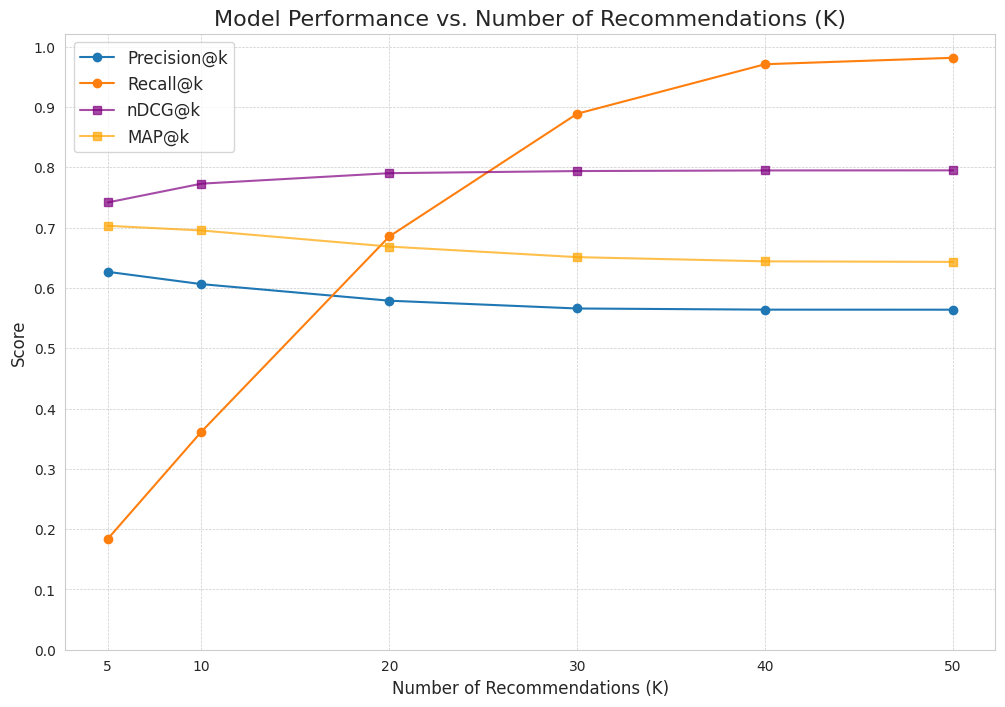

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Plot all metrics vs. K
plt.plot(results_df['k'], results_df['precision'], 'o-', label='Precision@k')
plt.plot(results_df['k'], results_df['recall'], 'o-', label='Recall@k')
plt.plot(results_df['k'], results_df['ndcg'], 's-', label='nDCG@k', color='purple', alpha=0.7)
plt.plot(results_df['k'], results_df['map'], 's-', label='MAP@k', color='orange', alpha=0.7)


plt.title('Model Performance vs. Number of Recommendations (K)', fontsize=16)
plt.xlabel('Number of Recommendations (K)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(k_values)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()